In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('WCE-CR.csv',  index_col=0)

data.columns = data.columns.str.lower().str.replace(' ', '_')

data = data.applymap(
    lambda x: x.lower() if (isinstance(x, str)) else x
)

In [3]:
data.head(3)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name
0,767,33,NaN,absolutely wonderful - silky and sexy and comf...,4,1,0,initmates,intimate,intimates
1,1080,34,NaN,love this dress! it's sooo pretty. i happene...,5,1,4,general,dresses,dresses
2,1077,60,some major design flaws,i had such high hopes for this dress and reall...,3,0,0,general,dresses,dresses


In [4]:
data.shape

(23486, 10)

In [5]:
## verify for null values
data.isnull().sum()

clothing_id                   0
age                           0
title                      3810
review_text                 845
rating                        0
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
dtype: int64

In [6]:
# considering that we use the review, we drop title and all null values
data.drop(columns='title', inplace=True)
data.dropna(inplace=True)
print(data.shape)
data.isnull().sum()

(22628, 9)


clothing_id                0
age                        0
review_text                0
rating                     0
recommended_ind            0
positive_feedback_count    0
division_name              0
department_name            0
class_name                 0
dtype: int64

In [7]:
data['clothing_id'] = data.clothing_id.astype('str')
data['rating'] = data.rating.astype('str')

In [8]:
## preprocessing data
import nltk
from nltk.corpus import stopwords

In [9]:
## removing stopwords and special characters and more
stop = stopwords.words('english') \
        + ['!', ',', '.', ';', ':', '?', '-', 
           '(<br/>)', '(<a).*(>).*(</a>)', '(&amp)', '(&gt)',
           '(&lt)', '(\xa0)']
# Create a function to remove stopwords and punctuation
def remove_stopwords_and_punctuation(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in stop]
    text = ' '.join(text)
    return text

In [10]:
data['review_text'] = np.vectorize(
    remove_stopwords_and_punctuation
)(data.review_text)

## setting the train-val-test dataset

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(data, test_size=0.20, random_state=1)

In [13]:
## define test size to be the 20% of the full df, you can do it by
# 20%/80% = 1/4
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=1
)

In [14]:
len(df_train), len(df_val), len(df_test)

(13576, 4526, 4526)

In [15]:
# avoid the random index
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [16]:
## get the rarget variable
y_train = df_train.recommended_ind.values
y_val = df_val.recommended_ind.values
y_test = df_test.recommended_ind.values

In [17]:
del df_train['recommended_ind']
del df_val['recommended_ind']
del df_test['recommended_ind']

## EDA

In [18]:
df_full_train.reset_index(drop=True, inplace=True)

In [19]:
df_full_train.recommended_ind.value_counts(normalize=True)

1    0.819909
0    0.180091
Name: recommended_ind, dtype: float64

In [20]:
## the problem is that the dataset is imbalanced, we work a bit with this
from imblearn.over_sampling import RandomOverSampler

In [21]:
ros = RandomOverSampler(random_state=42)
df_train_resampled, y_train_resampled = ros.fit_resample(df_train, y_train)

In [22]:
## next steeps: identify the categorical and numerical vars
# feature importance
# one hot encoding

In [25]:
numerical = ['age', 'positive_feedback_count']
categorical = [
    'rating', 'division_name', 'department_name','class_name'
]

In [26]:
df_full_train[categorical].nunique()

rating              5
division_name       3
department_name     6
class_name         19
dtype: int64

## One-hot encoding

In [27]:
from sklearn.feature_extraction import DictVectorizer

In [28]:
train_dicts = df_train_resampled[categorical + numerical].to_dict(orient='records')

In [29]:
dv = DictVectorizer(sparse=False)

In [30]:
X_train = dv.fit_transform(train_dicts)

In [31]:
dv.get_feature_names_out()

array(['age', 'class_name=blouses', 'class_name=dresses',
       'class_name=fine gauge', 'class_name=intimates',
       'class_name=jackets', 'class_name=jeans', 'class_name=knits',
       'class_name=layering', 'class_name=legwear', 'class_name=lounge',
       'class_name=outerwear', 'class_name=pants', 'class_name=shorts',
       'class_name=skirts', 'class_name=sleep', 'class_name=sweaters',
       'class_name=swim', 'class_name=trend', 'department_name=bottoms',
       'department_name=dresses', 'department_name=intimate',
       'department_name=jackets', 'department_name=tops',
       'department_name=trend', 'division_name=general',
       'division_name=general petite', 'division_name=initmates',
       'positive_feedback_count', 'rating=1', 'rating=2', 'rating=3',
       'rating=4', 'rating=5'], dtype=object)

In [32]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

### getting the hidden layers to be added to the model

In [33]:
from transformers import AutoTokenizer
from transformers import AutoModel
from datasets import Dataset
import torch

In [34]:
model_ckpt = 'distilbert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['review_text'], padding=True, truncation=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
df_train_hf = Dataset.from_pandas(df_train_resampled)

In [37]:
reviews_encoded = df_train_hf.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/22238 [00:00<?, ? examples/s]

In [38]:
## extracting the last hidden state of the whole dataset
# by creating a new hidden state column that stores the vector 
def extract_hidden_states(batch):
    # place it in a GPU, if the items are on the model inputs
    inputs = {
        k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names
    }

    # extract the last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # return the [CLS] token
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [39]:
reviews_encoded.set_format(
    "torch", columns=["input_ids", "attention_mask"]
)

In [40]:
reviews_hidden = reviews_encoded.map(
    extract_hidden_states, batched=True, batch_size=600)

Map:   0%|          | 0/22238 [00:00<?, ? examples/s]

In [41]:
df_val_hf = Dataset.from_pandas(df_val)

In [42]:
reviews_encoded_val = df_val_hf.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/4526 [00:00<?, ? examples/s]

In [43]:
reviews_encoded_val.set_format(
    "torch", columns=["input_ids", "attention_mask"]
)

In [44]:
reviews_hidden_val = reviews_encoded_val.map(
    extract_hidden_states, batched=True, batch_size=600)

Map:   0%|          | 0/4526 [00:00<?, ? examples/s]

In [45]:
hidden_train = np.array(reviews_hidden['hidden_state'])
hidden_val = np.array(reviews_hidden_val['hidden_state'])

In [46]:
hidden_train.shape

(22238, 768)

In [47]:
X_train.shape

(22238, 34)

## logistic regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [49]:
X_train_all = np.concatenate((X_train, hidden_train), axis = 1)
X_val_all = np.concatenate((X_val, hidden_val), axis = 1)

In [51]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=3000))
pipe.fit(X_train_all, y_train_resampled)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [ ]:
pipe.named_steps['logisticregression'].coef_[0]

In [52]:
y_pred = pipe.predict_proba(X_val_all)[:, 1]

In [53]:
recommendation = (y_pred >= 0.5)

In [54]:
(y_val == recommendation).mean()

0.9264250994255413

In [55]:
## generating the cnfusion matrix for our classifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title("normalized confusion matrix")
    plt.show()

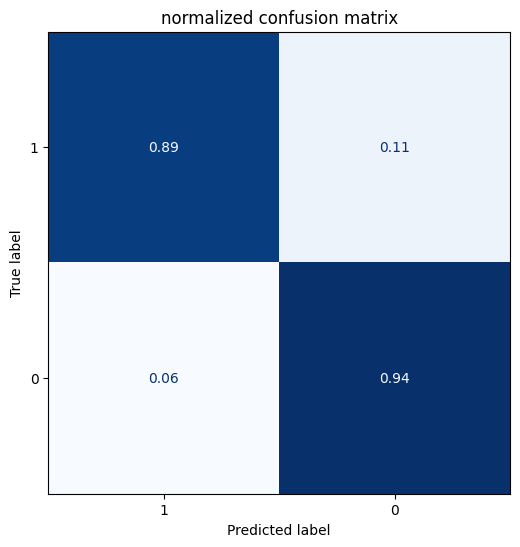

In [56]:
labels = data.recommended_ind.unique()

y_preds = pipe.predict(X_val_all)
plot_confusion_matrix(y_preds, y_val, labels)

In [57]:
from sklearn.metrics import roc_curve

In [58]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

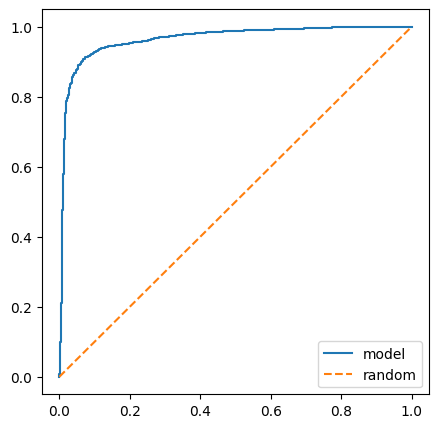

In [59]:
## plotting the FPR and TPR

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')
plt.legend()
plt.show()